In [34]:
# Imports
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torchvision import transforms

# Paths Initialization
folder_benign_train_path = 'images/data/train/benign'
folder_malignant_train_path = 'images/data/train/malignant'

folder_benign_test_path = 'images/data/test/benign'
folder_malignant_test_path = 'images/data/test/malignant'


In [35]:
def read_and_resize(imgname, size=(224, 224)):
    """
    Reads an image, resizes it to a given size, and normalizes pixel values to [0, 1].
    Args:
        imgname (str): Path to the image file.
        size (tuple): Target size for the image (width, height).
    Returns:
        np.array: Resized and normalized image as a NumPy array.
    """
    img = Image.open(imgname).convert("RGB")  # Ensure RGB format
    img_resized = img.resize(size)           # Resize the image
    return np.asarray(img_resized, dtype='float32') / 255.0  # Normalize to [0, 1]

def prepareimages(folder_benign_path, folder_malignant_path, size=(224, 224)):
    """ 
    Reads and preprocesses images from benign and malignant folders.
    Args:
        folder_benign_path (str): Path to the benign images folder.
        folder_malignant_path (str): Path to the malignant images folder.
        size (tuple): Target size for all images (default = (224, 224)).
    Returns:
        tuple: X (images) and y (labels) arrays, and lengths of individual datasets.
    """
    # Load and preprocess benign images
    imgs_benign = [read_and_resize(os.path.join(folder_benign_path, filename), size) 
                   for filename in os.listdir(folder_benign_path) 
                   if filename.endswith(('.png', '.jpg', '.jpeg'))]
    X_benign = np.array(imgs_benign, dtype='float32')  # Convert list to numpy array
    y_benign = np.zeros(len(X_benign))  # Labels for benign images: 0

    # Load and preprocess malignant images
    imgs_malignant = [read_and_resize(os.path.join(folder_malignant_path, filename), size) 
                      for filename in os.listdir(folder_malignant_path) 
                      if filename.endswith(('.png', '.jpg', '.jpeg'))]
    X_malignant = np.array(imgs_malignant, dtype='float32')  # Convert list to numpy array
    y_malignant = np.ones(len(X_malignant))  # Labels for malignant images: 1

    # Combine benign and malignant data
    X = np.concatenate((X_benign, X_malignant), axis=0)
    y = np.concatenate((y_benign, y_malignant), axis=0)

    return X, y, len(X_benign), len(X_malignant)


In [26]:
def read_and_resize(imgname, size=(224, 224)):
    """
    Reads an image, resizes it to a given size, and normalizes pixel values to [0, 1].
    Args:
        imgname (str): Path to the image file.
        size (tuple): Target size for the image (width, height).
    Returns:
        np.array: Resized and normalized image as a NumPy array.
    """
    img = Image.open(imgname).convert("RGB")  # Ensure RGB format
    img_resized = img.resize(size)           # Resize the image
    return np.asarray(img_resized, dtype='float32') / 255.0  # Normalize to [0, 1]

def prepareimages(folder_benign_path, folder_malignant_path, size=(224, 224)):
    """ 
    Reads and preprocesses images from benign and malignant folders.
    Args:
        folder_benign_path (str): Path to the benign images folder.
        folder_malignant_path (str): Path to the malignant images folder.
        size (tuple): Target size for all images (default = (224, 224)).
    Returns:
        tuple: X (images) and y (labels) arrays, and lengths of individual datasets.
    """
    # Load and preprocess benign images
    imgs_benign = [read_and_resize(os.path.join(folder_benign_path, filename), size) 
                   for filename in os.listdir(folder_benign_path) 
                   if filename.endswith(('.png', '.jpg', '.jpeg'))]
    X_benign = np.array(imgs_benign, dtype='float32')  # Convert list to numpy array
    y_benign = np.zeros(len(X_benign))  # Labels for benign images: 0

    # Load and preprocess malignant images
    imgs_malignant = [read_and_resize(os.path.join(folder_malignant_path, filename), size) 
                      for filename in os.listdir(folder_malignant_path) 
                      if filename.endswith(('.png', '.jpg', '.jpeg'))]
    X_malignant = np.array(imgs_malignant, dtype='float32')  # Convert list to numpy array
    y_malignant = np.ones(len(X_malignant))  # Labels for malignant images: 1

    # Combine benign and malignant data
    X = np.concatenate((X_benign, X_malignant), axis=0)
    y = np.concatenate((y_benign, y_malignant), axis=0)

    return X, y, len(X_benign), len(X_malignant)


In [36]:
def shuffle_data(X, y):
    """
    Shuffles the data to avoid any ordering bias.
    Args:
        X (np.array): Images array.
        y (np.array): Labels array.
    Returns:
        tuple: Shuffled X and y arrays.
    """
    s = np.arange(X.shape[0])  # Array of indices
    np.random.shuffle(s)       # Shuffle indices
    X = X[s]
    y = y[s]
    return X, y


In [37]:
# Prepare Training Data
X_train, y_train, len_benign_train, len_malignant_train = prepareimages(folder_benign_train_path, folder_malignant_train_path, size=(224, 224))
X_train, y_train = shuffle_data(X_train, y_train)

# Prepare Testing Data
X_test, y_test, len_benign_test, len_malignant_test = prepareimages(folder_benign_test_path, folder_malignant_test_path, size=(224, 224))
X_test, y_test = shuffle_data(X_test, y_test)


In [38]:
class SkinCancerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [39]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [40]:
# Create Datasets
train_dataset = SkinCancerDataset(X_train, y_train, transform=transform)
test_dataset = SkinCancerDataset(X_test, y_test, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


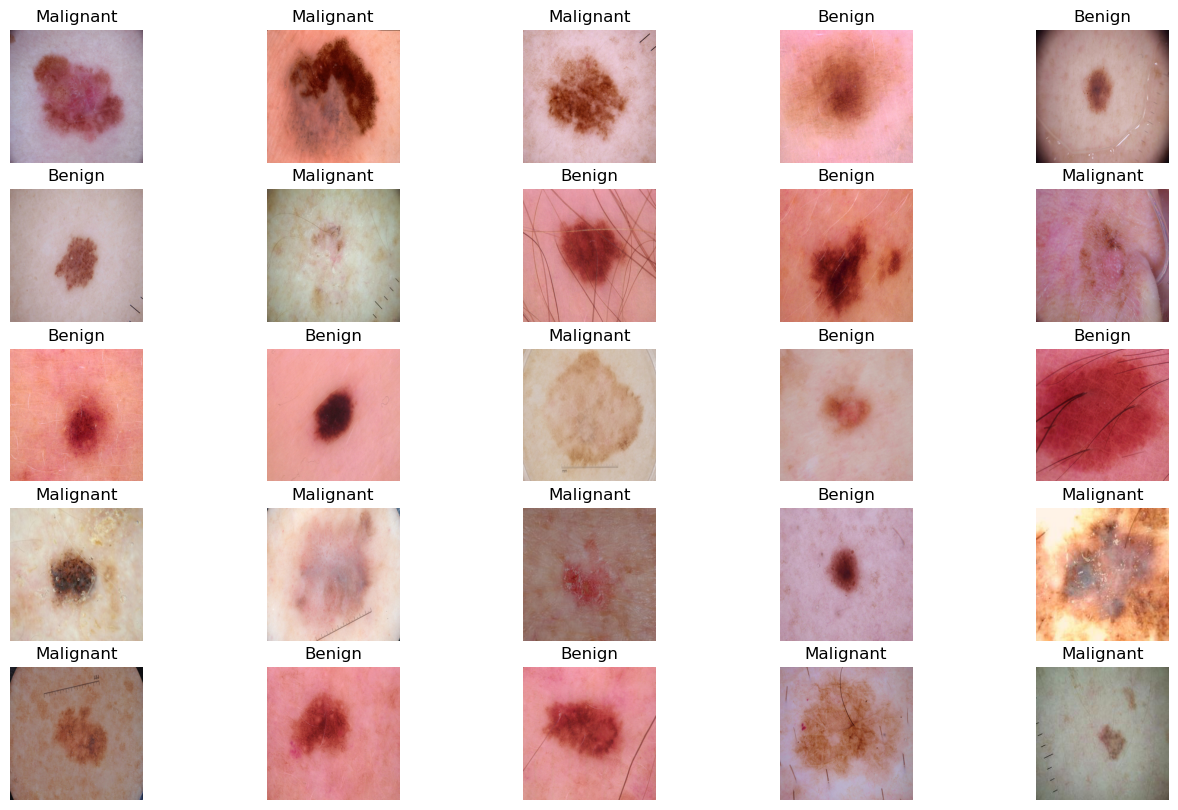

In [45]:
w=40
h=30
fig=plt.figure(figsize=(16, 10))
columns = 5
rows = 5

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i])
    plt.axis("off")
plt.show()

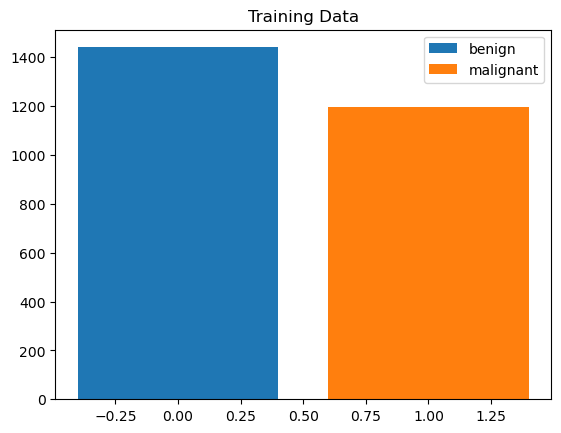

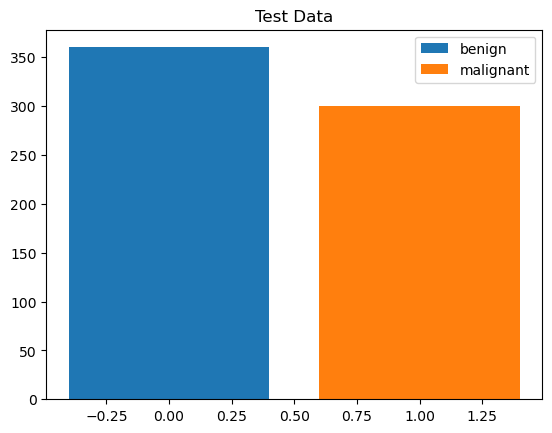

In [46]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()

In [48]:
# class CNNModel(nn.Module):
#     def __init__(self):
#         super(CNNModel, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(128*28*28, 512)
#         self.fc2 = nn.Linear(512, 1)

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv3(x))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
# Initialize Model, Loss Function, and Optimizer
# model = CNNModel().cuda()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
